In [1]:
import os

In [2]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

Found existing installation: Keras 2.1.6
Uninstalling Keras-2.1.6:
  Successfully uninstalled Keras-2.1.6


Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0


In [3]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.1.6
!pip install h5py==2.10.0
import tensorflow
print(tensorflow.__version__)
!pip install mrcnn-colab

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageai 2.1.6 requires keras==2.4.3, which is not installed.
imageai 2.1.6 requires h5py==2.10.0, but you have h5py 3.6.0 which is incompatible.
imageai 2.1.6 requires numpy==1.19.3, but you have numpy 1.21.5 which is incompatible.
imageai 2.1.6 requires pillow==7.0.0, but you have pillow 8.3.2 which is incompatible.
imageai 2.1.6 requires scipy==1.4.1, but you have scipy 1.7.3 which is incompatible.
You should consider upgrading via the 'd:\2. python\python 3.7\python.exe -m pip install --upgrade pip' command.


  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.6.0-cp37-cp37m-win_amd64.whl (2.8 MB)
  Using cached Keras-2.1.6-py2.py3-none-any.whl (339 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-resnet 0.2.0 requires keras>=2.2.4, but you have keras 2.1.6 which is incompatible.
imageai 2.1.6 requires h5py==2.10.0, but you have h5py 3.6.0 which is incompatible.
imageai 2.1.6 requires keras==2.4.3, but you have keras 2.1.6 which is incompatible.
imageai 2.1.6 requires numpy==1.19.3, but you have numpy 1.21.5 which is incompatible.
imageai 2.1.6 requires pillow==7.0.0, but you have pillow 8.3.2 which is incompatible.
imageai 2.1.6 requires scipy==1.4.1, but you have scipy 1.7.3 which is incompatible.
You should consider upgrading via the 'd:\2. python\python 3.7\python.exe -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageai 2.1.6 requi

  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0
1.15.0


You should consider upgrading via the 'd:\2. python\python 3.7\python.exe -m pip install --upgrade pip' command.


# Training

In [4]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
import imageio

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
#COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_WEIGHTS_PATH = ".\logs\object20220209T1625\mask_rcnn_object_0150.h5"
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
print(COCO_WEIGHTS_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
print(DEFAULT_LOGS_DIR)

d:\2. python\python 3.7\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


.\logs\object20220209T1625\mask_rcnn_object_0150.h5
E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom resnet 101\logs


Using TensorFlow backend.


In [5]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + object

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    print(NUM_CLASSES)

4


In [6]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or test
        """
        # Add classes. We have only one class to add.
        #self.add_class("object", 1, "Individual")
        self.add_class("object", 1, "Person")
        self.add_class("object", 2, "Group")
        self.add_class("object", 3, "Crowd")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each regionv
        
        ### annotations = list(annotations.values()) is not present BEFORE the code below
        annotations = []
        annotation = json.load(open(os.path.join(dataset_dir, "train.json"))) 
        via_1_check = annotation.get('regions')
        via_2_check = annotation.get('_via_img_metadata')
        
        # JSON is formatted with VIA-1.x
        if via_1_check:
            annotations = list(annotation.values()) # don't need the dict keys
        # JSON is formatted with VIA-2.x
        elif via_2_check:
            annotations = list(annotation['_via_img_metadata'].values()) # don't need the dict keys
        # Unknown JSON formatting
        else:
            raise ValueError('The JSON provided is not in a recognised via-1.x or via-2.x format.')

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Person": 1,"Group": 2, "Crowd":3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
            
    def load_val(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #self.add_class("object", 1, "Individual")
        self.add_class("object", 1, "Person")
        self.add_class("object", 2, "Group")
        self.add_class("object", 3, "Crowd")

        # Train or testing dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each regionv
        
        ### annotations = list(annotations.values()) is not present BEFORE the code below
        annotations = []
        annotation = json.load(open(os.path.join(dataset_dir, "val.json"))) 
        via_1_check = annotation.get('regions')
        via_2_check = annotation.get('_via_img_metadata')
        
        # JSON is formatted with VIA-1.x
        if via_1_check:
            annotations = list(annotation.values()) # don't need the dict keys
        # JSON is formatted with VIA-2.x
        elif via_2_check:
            annotations = list(annotation['_via_img_metadata'].values()) # don't need the dict keys
        # Unknown JSON formatting
        else:
            raise ValueError('The JSON provided is not in a recognised via-1.x or via-2.x format.')

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Person": 1,"Group": 2, "Crowd":3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Transfer Learning

In [7]:
import warnings 
warnings.filterwarnings("ignore")

config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

In [9]:
#model.load_weights(weights_path, by_name=True, exclude=[
            #"mrcnn_class_logits", "mrcnn_bbox_fc",
            #"mrcnn_bbox", "mrcnn_mask"])
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])







Re-starting from epoch 150


In [10]:
"""Train the model."""
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("./dataset", "train")
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

# Testing dataset
dataset_val = CustomDataset()
dataset_val.load_val("./dataset", "val")
dataset_val.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

# *** This training schedule is an example. Update to your needs ***
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.

print("Training network heads")


objects: ['Person', 'Person', 'Person', 'Group', 'Person']
numids [1, 1, 1, 2, 1]
objects: ['Group', 'Person', 'Group', 'Person', 'Person']
numids [2, 1, 2, 1, 1]
objects: ['Person', 'Group', 'Group', 'Person', 'Person']
numids [1, 2, 2, 1, 1]
objects: ['Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Group', 'Person']
numids [1, 1, 1, 2, 1]
objects: ['Person', 'Person', 'Person', 'Group']
numids [1, 1, 1, 2]
objects: ['Crowd', 'Group', 'Person', 'Group', 'Person', 'Person']
numids [3, 2, 1, 2, 1, 1]
objects: ['Person', 'Person', 'Person', 'Crowd', 'Person', 'Person', 'Person', 'Group', 'Person', 'Crowd', 'Person']
numids [1, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1]
objects: ['Person', 'Person', 'Group', 'Person', 'Group', 'Crowd', 'Person', 'Group', 'Person', 'Person']
numids [1, 1, 2, 1, 2, 3, 1, 2, 1, 1]
objects: ['Crowd', 'Group', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person']
numids [3, 

objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Person', 'Person', 'Group']
numids [1, 1, 1, 1, 1, 2]
objects: ['Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 1, 1, 1, 1, 1, 1]
objects: ['Group', 'Group', 'Group', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 2, 1, 1, 1, 1]
objects: ['Crowd', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [3, 1, 2, 1, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Group', 'Person']
numids [3, 1, 1, 2, 1]
objects: ['Crowd', 'Person', 'Group', 'Person', 'Person']
numids [3, 1, 2, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Crowd', 'Group']
numids [3, 1, 1, 1, 1, 1, 1, 3, 2]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Group', 'Group', 'Person']
numids [2, 1, 1, 1, 1, 1, 1, 2, 2, 1]
objects: ['Person', 'Group', 'Person', 'Person', 

objects: ['Group', 'Group', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 1, 2, 1, 1, 1, 1, 1, 1]
objects: ['Group', 'Group', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 2, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Group']
numids [2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1, 1, 2, 1, 1, 1]
objects: ['Group', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 1, 2, 1, 1, 1, 1, 1]
objects: ['Group', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1

numids [3, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Crowd', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person']
numids [2, 1, 3, 1, 1, 2, 1, 1, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Crowd', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 1, 1, 3, 2, 1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Crowd', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 

objects: ['Group', 'Group', 'Group', 'Person']
numids [2, 2, 2, 1]
objects: ['Crowd', 'Group', 'Crowd', 'Person']
numids [3, 2, 3, 1]
objects: ['Group', 'Group', 'Crowd', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 2, 3, 1, 2, 1, 1, 1]
objects: ['Person', 'Group', 'Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 2, 1, 2, 1, 1, 1, 1, 1]
objects: ['Person', 'Group', 'Person', 'Group', 'Group', 'Group', 'Group', 'Person', 'Person']
numids [1, 2, 1, 2, 2, 2, 2, 1, 1]
objects: ['Person', 'Group', 'Group', 'Person', 'Group', 'Group']
numids [1, 2, 2, 1, 2, 2]
objects: ['Person', 'Person', 'Person', 'Group']
numids [1, 1, 1, 2]
objects: ['Group', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 1, 2, 1, 1, 1]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Group', 'Person']
numids [2, 1, 1, 1, 1, 2, 1]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numi

objects: ['Person', 'Person', 'Group']
numids [1, 1, 2]
objects: ['Group', 'Person', 'Person', 'Group']
numids [2, 1, 1, 2]
objects: ['Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1]
objects: ['Person', 'Person', 'Group', 'Crowd']
numids [1, 1, 2, 3]
objects: ['Group', 'Group', 'Person', 'Group']
numids [2, 2, 1, 2]
objects: ['Person', 'Group', 'Person', 'Person', 'Person', 'Person']
numids [1, 2, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Person', 'Crowd', 'Person']
numids [2, 1, 1, 3, 1]
objects: ['Person', 'Group', 'Person', 'Person', 'Group']
numids [1, 2, 1, 1, 2]
objects: ['Group', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person']
numids [2, 1, 1, 1, 2, 1, 1]
objects: ['Group', 'Crowd', 'Person', 'Person']
numids [2, 3, 1, 1]
objects: ['Person', 'Person', 'Person']
numids [1, 1, 1]
objects: ['Group', 'Person']
numids [2, 1]
objects: ['Person', 'Person', 'Pe

objects: ['Person', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 2, 1, 1, 1, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Group', 'Person', 'Group', 'Person', 'Person']
numids [1, 1, 1, 2, 1, 2, 1, 1]
objects: ['Person', 'Person', 'Group', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [1, 1, 2, 1, 1, 2, 1, 1, 1]
objects: ['Person', 'Group', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [1, 2, 2, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Group', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 1, 2, 1, 1, 2, 1, 1, 1]
objects: ['Group', 'Group', 'Person', 'Group', 'Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Person', 'Group', 'Group', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 2, 2, 1, 2, 1, 1, 1]
objects: ['Group', 'Group', 'Group', 'Group', 'Person', 'Person', 'Person

objects: ['Group', 'Group', 'Person', 'Person']
numids [2, 2, 1, 1]
objects: ['Group', 'Person', 'Group', 'Person']
numids [2, 1, 2, 1]
objects: ['Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1]
objects: ['Group', 'Person']
numids [2, 1]
Images: 146
Classes: ['BG', 'Person', 'Group', 'Crowd']
Training network heads


## Training Model

In [81]:
LEARNING_RATE = 0.001

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE*10,
            #Epochnya diganti
            epochs=20,
            layers='heads')
history = model.keras_model.history.history


Starting at epoch 129. LR=0.01

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

In [68]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE*5, 
            #Epochnya diganti
            epochs=30,  
            layers="all")

#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]

#import csv
#w = csv.writer(open("output2.csv", "w"))
# loop over dictionary keys and values
#for key, val in history.items():
    # write every key and value to file
    #w.writerow([key, val])


Starting at epoch 150. LR=0.005

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

In [69]:
#history = model.keras_model.history.history

In [70]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE*5, 
            #Epochnya diganti
            epochs=60,  
            layers="all")


Starting at epoch 150. LR=0.005

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

In [71]:
model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE, 
        #Epochnya diganti
        epochs=100,  
        layers="all")


Starting at epoch 150. LR=0.001

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

In [11]:
model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE, 
        #Epochnya diganti
        epochs=130,  
        layers="all")
#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]
#w = csv.writer(open("output.csv", "w"))
####### loop over dictionary keys and values
#for key, val in history.items():
    # write every key and value to file
    #w.writerow([key, val])


Starting at epoch 129. LR=0.001

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b






Epoch 130/130
10/10 [==============================] - 609s 61s/step - loss: 1.8772 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.5172 - mrcnn_bbox_loss: 0.4842 - mrcnn_mask_loss: 0.7978 - val_loss: 1.7104 - val_rpn_class_loss: 0.0137 - val_rpn_bbox_loss: 0.2136 - val_mrcnn_class_loss: 0.4372 - val_mrcnn_bbox_loss: 0.4608 - val_mrcnn_mask_loss: 0.5850



In [12]:
model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE, 
        #Epochnya diganti
        epochs=150,  
        layers="all")
#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]
#w = csv.writer(open("output.csv", "w"))
####### loop over dictionary keys and values
#for key, val in history.items():
    # write every key and value to file
    #w.writerow([key, val])


Starting at epoch 130. LR=0.001

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

Epoch 131/150
10/10 [==============================] - 566s 57s/step - loss: 1.4433 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.3762 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.5281 - val_loss: 1.4854 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 0.2432 - val_mrcnn_class_loss: 0.3539 - val_mrcnn_bbox_loss: 0.4462 - val_mrcnn_mask_loss: 0.4201
Epoch 132/150
10/10 [==============================] - 555s 55s/step - loss: 0.9564 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.3157 - val_loss: 1.1810 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.2040 - val_mrcnn_class_loss: 0.2957 - val_mrcnn_bbox_loss: 0.3786 - val_mrcnn_mask_loss: 0.2857
Epoch 133/150
10/10 [==============================] - 564s 56s/step - loss: 1.0863 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.3358 - mrcnn_bbox_loss: 0.3697 - mrcnn_mask_loss: 0.2792 - val_loss: 1.0432 - val_rpn_c

In [11]:
model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE/5, 
        #Epochnya diganti
        epochs=170,  
        layers="all")
#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]
#w = csv.writer(open("output.csv", "w"))
####### loop over dictionary keys and values
#for key, val in history.items():
    # write every key and value to file
    #w.writerow([key, val])


Starting at epoch 150. LR=0.0002

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom resnet 101\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchN






Epoch 151/170
10/10 [==============================] - 539s 54s/step - loss: 2.0717 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.2926 - mrcnn_bbox_loss: 0.6739 - mrcnn_mask_loss: 1.0096 - val_loss: 2.1997 - val_rpn_class_loss: 0.0260 - val_rpn_bbox_loss: 0.3032 - val_mrcnn_class_loss: 0.3226 - val_mrcnn_bbox_loss: 0.6712 - val_mrcnn_mask_loss: 0.8767

Epoch 152/170
10/10 [==============================] - 534s 53s/step - loss: 1.6864 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.7736 - val_loss: 1.9074 - val_rpn_class_loss: 0.0399 - val_rpn_bbox_loss: 0.3295 - val_mrcnn_class_loss: 0.3318 - val_mrcnn_bbox_loss: 0.5490 - val_mrcnn_mask_loss: 0.6573
Epoch 153/170
10/10 [==============================] - 527s 53s/step - loss: 1.5883 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.3574 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.5941 - val_loss: 1.6323 - val

Epoch 170/170
10/10 [==============================] - 530s 53s/step - loss: 0.5298 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2078 - val_loss: 0.9567 - val_rpn_class_loss: 0.0276 - val_rpn_bbox_loss: 0.2844 - val_mrcnn_class_loss: 0.1562 - val_mrcnn_bbox_loss: 0.2351 - val_mrcnn_mask_loss: 0.2534


In [12]:
model.train(dataset_train, dataset_val, 
        learning_rate=config.LEARNING_RATE/10, 
        #Epochnya diganti
        epochs=200,  
        layers="all")
#new_history = model.keras_model.history.history
#for k in new_history: history[k] = history[k] + new_history[k]
#w = csv.writer(open("output.csv", "w"))
####### loop over dictionary keys and values
#for key, val in history.items():
    # write every key and value to file
    #w.writerow([key, val])


Starting at epoch 170. LR=0.0001

Checkpoint Path: E:\21. Coding Tesis\2.2 Code Python Dataset Pasar Atom resnet 101\logs\object20220209T1625\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchN

Epoch 171/200
10/10 [==============================] - 565s 57s/step - loss: 0.5201 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.2042 - val_loss: 0.9878 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.3242 - val_mrcnn_class_loss: 0.1355 - val_mrcnn_bbox_loss: 0.2473 - val_mrcnn_mask_loss: 0.2522
Epoch 172/200
10/10 [==============================] - 553s 55s/step - loss: 0.5030 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2059 - val_loss: 1.1544 - val_rpn_class_loss: 0.0433 - val_rpn_bbox_loss: 0.4440 - val_mrcnn_class_loss: 0.1565 - val_mrcnn_bbox_loss: 0.2478 - val_mrcnn_mask_loss: 0.2628
Epoch 173/200
10/10 [==============================] - 551s 55s/step - loss: 0.5083 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1965 - val_loss: 1.0117 - val_rpn_c

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs

## Testing

In [22]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import json
import skimage.draw
import cv2
from mrcnn.visualize import display_instances

# Root directory of the project
#ROOT_DIR = os.path.abspath("/")
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases

In [23]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + toy

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 2

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    print(NUM_CLASSES)

4


In [24]:
class TestDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Person")
        self.add_class("object", 2, "Group")
        self.add_class("object", 3, "Crowd")
        
        # Train or validation dataset?
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        #annotations1 = json.load(open(os.path.join(dataset_dir, "test.json")))
        annotations1 = json.load(open(os.path.join(dataset_dir, "val.json")))
        print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
        
        ### annotations = list(annotations.values()) is not present BEFORE the code below
        annotations = []
        #annotation = json.load(open(os.path.join(dataset_dir, "test.json"))) 
        annotation = json.load(open(os.path.join(dataset_dir, "val.json"))) 
        via_1_check = annotation.get('regions')
        via_2_check = annotation.get('_via_img_metadata')

        # JSON is formatted with VIA-1.x
        if via_1_check:
            annotations = list(annotation.values()) # don't need the dict keys
        # JSON is formatted with VIA-2.x
        elif via_2_check:
            annotations = list(annotation['_via_img_metadata'].values()) # don't need the dict keys
        # Unknown JSON formatting
        else:
            raise ValueError('The JSON provided is not in a recognised via-1.x or via-2.x format.')

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Person": 1,"Group": 2,"Crowd":3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [25]:
config = CustomConfig()
#CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/15. R-CNN TESIS/SEMESTER_8/MASK_RCNN/dataset/testing")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [26]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [27]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [28]:
# Load validation dataset
CUSTOM_DIR = "./dataset"
dataset = TestDataset()
#dataset.load_custom(CUSTOM_DIR, "test")
dataset.load_custom(CUSTOM_DIR, "val")


# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

{'_via_settings': {'ui': {'annotation_editor_height': 25, 'annotation_editor_fontsize': 0.8, 'leftsidebar_width': 18, 'image_grid': {'img_height': 80, 'rshape_fill': 'none', 'rshape_fill_opacity': 0.3, 'rshape_stroke': 'yellow', 'rshape_stroke_width': 2, 'show_region_shape': True, 'show_image_policy': 'all'}, 'image': {'region_label': 'name', 'region_color': '__via_default_region_color__', 'region_label_font': '10px Sans', 'on_image_annotation_editor_placement': 'NEAR_REGION'}}, 'core': {'buffer_size': 18, 'filepath': {}, 'default_filepath': ''}, 'project': {'name': 'test'}}, '_via_img_metadata': {'Images_video1_75.jpg580274': {'filename': 'Images_video1_75.jpg', 'size': 580274, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [733, 740, 759, 765, 792, 834, 822, 814, 802, 796, 781, 765, 749], 'all_points_y': [483, 558, 578, 604, 609, 572, 518, 476, 450, 434, 429, 438, 451]}, 'region_attributes': {'name': 'Group'}}, {'shape_attributes': {'name': 'polygon', 'all_point

objects: ['Person', 'Crowd', 'Person', 'Person', 'Person', 'Group', 'Crowd', 'Person', 'Group', 'Person', 'Person']
numids [1, 3, 1, 1, 1, 2, 3, 1, 2, 1, 1]
objects: ['Group', 'Crowd', 'Person', 'Person', 'Group', 'Person', 'Group', 'Person']
numids [2, 3, 1, 1, 2, 1, 2, 1]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Person']
numids [2, 1, 1]
objects: ['Person', 'Person', 'Group']
numids [1, 1, 2]
objects: ['Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1]
objects: ['Person', 'Person', 'Person', 'Group', 'Group', 'Crowd', 'Person', 'Person']
numids [1, 1, 1, 2, 2, 3, 1, 1]
objects: ['Group', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1, 1, 1, 1]
objects: ['Group', 'Person', 'Group', 'Person', 'Person']
numids [2, 1, 2, 1, 1]
objects: ['Group', 'Group', 'Person', 'Person']
numids [2, 2, 1, 1]
objects: ['Group', 'Group', 'Person', 'Person', 'Person']
numids [2, 2, 1

objects: ['Group', 'Group', 'Group', 'Person', 'Group']
numids [2, 2, 2, 1, 2]
objects: ['Person', 'Person', 'Person', 'Group', 'Person']
numids [1, 1, 1, 2, 1]
objects: ['Person', 'Person', 'Person', 'Person']
numids [1, 1, 1, 1]
objects: ['Person', 'Person', 'Group']
numids [1, 1, 2]
objects: ['Group', 'Person', 'Person', 'Person', 'Group', 'Person', 'Person', 'Person']
numids [2, 1, 1, 1, 2, 1, 1, 1]
objects: ['Crowd', 'Person', 'Person', 'Person']
numids [3, 1, 1, 1]
objects: ['Group', 'Crowd', 'Person']
numids [2, 3, 1]
objects: ['Group', 'Person', 'Person', 'Group', 'Group']
numids [2, 1, 1, 2, 2]
objects: ['Crowd', 'Person', 'Person']
numids [3, 1, 1]
objects: ['Crowd', 'Person', 'Group', 'Person', 'Group', 'Group', 'Person', 'Person', 'Group']
numids [3, 1, 2, 1, 2, 2, 1, 1, 2]
objects: ['Crowd', 'Group', 'Group', 'Group', 'Person', 'Person', 'Group', 'Person', 'Group', 'Person']
numids [3, 2, 2, 2, 1, 1, 2, 1, 2, 1]
objects: ['Group', 'Crowd', 'Person', 'Group', 'Person', 'Gro

In [29]:
#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



Instructions for updating:
Use `tf.cast` instead.


In [30]:
# Load COCO weights, Or load the last model you trained
WEIGHTS_PATH = ".\logs\object20220209T1625\mask_rcnn_object_0124.h5"  # TODO: update this path
weights_path = WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

#Best Model :124

Loading weights  .\logs\object20220209T1625\mask_rcnn_object_0124.h5
Re-starting from epoch 124


In [20]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 15 images. Increase for better accuracy.

image_ids = []
for i in range (0,146):
    image_ids.append(i)
APs = []
All_Prec = []
All_Rec = []
Prec_mean =[]
Rec_mean = []
F1_scores =[]

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    All_Prec.append(precisions)
    All_Rec.append(recalls)
    Prec_mean.append(np.mean(precisions))
    Rec_mean.append(np.mean(recalls))
    F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))

#MAP = mean average precission


KeyboardInterrupt: 

In [42]:
print("Mean AP",np.mean(APs))
print("Precission mean",np.mean(Prec_mean))
print("Recall mean", np.mean(Rec_mean))
print("F1 Score", np.mean(F1_scores))

Mean AP 0.7017032879762755
Precission mean 0.7448905250477643
Recall mean 0.48801690574481094
F1 Score 0.5847201606548742


In [21]:
import utils_conf_matrix
from mrcnn import utils

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

#class_ids = {"Person": 1,"Group": 2, "Crowd":3}
#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils_conf_matrix.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])
    #print("Predicted object : "+dataset.class_names[pred])
    
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
import pandas as pd

df = pd.DataFrame(gt_pred_tot_json)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
    
#print the confusion matrix and compute true postives, false positives and false negative for each class: 
#ps : you can controle the figure size and text format by choosing the right values
#tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)

gt_tot = np.append(gt_tot, gt)
pred_tot = np.append(pred_tot, pred)

print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

#here i didnt set the columns list, since in the code if columns is note specified 
#it generates automatically a list from "class A" to "class ..". in this example, class A should be the background
#Note : class A is the backround in this example


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  6
the actual len of the pred vect is :  6
Average precision of this image :  0.8999999999999999
The actual mean average precision for the whole images (matterport methode)  0.8999999999999999
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.3539

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  127
the actual len of the pred vect is :  127
Average precision of this image :  0.5
The actual mean average precision for the whole images (matterport methode)  0.5980559959802508
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the

the actual len of the gt vect is :  242
the actual len of the pred vect is :  242
Average precision of this image :  0.6566666747132938
The actual mean average precision for the whole images (matterport methode)  0.6333011701337072
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  250
the actual len of the pred vect is :  250
Average precision of this image :  0.7755102132047925
The actual mean average precision for the whole images (matterport methode)  0.6383800645291032
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images         

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  386
the actual len of the pred vect is :  386
Average precision of this image :  0.9090909361839294
The actual mean average precision for the whole images (matterport methode)  0.6758340407545057
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.

the actual len of the gt vect is :  515
the actual len of the pred vect is :  515
Average precision of this image :  0.7777777777777778
The actual mean average precision for the whole images (matterport methode)  0.7176964196361887
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  529
the actual len of the pred vect is :  529
Average precision of this image :  0.6783216974952004
The actual mean average precision for the whole images (matterport methode)  0.7169805155972616
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images         

the actual len of the gt vect is :  654
the actual len of the pred vect is :  654
Average precision of this image :  0.6507936716079712
The actual mean average precision for the whole images (matterport methode)  0.7375869909256646
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  670
the actual len of the pred vect is :  670
Average precision of this image :  0.6626984175472033
The actual mean average precision for the whole images (matterport methode)  0.7364856883759813
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images         

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  748
the actual len of the pred vect is :  748
Average precision of this image :  0.7200000107288361
The actual mean average precision for the whole images (matterport methode)  0.7059180272539642
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.

the actual len of the gt vect is :  831
the actual len of the pred vect is :  831
Average precision of this image :  0.6874999925494194
The actual mean average precision for the whole images (matterport methode)  0.6801502365110531
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  845
the actual len of the pred vect is :  845
Average precision of this image :  0.48376069183533005
The actual mean average precision for the whole images (matterport methode)  0.6780829781460456
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images        

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  939
the actual len of the pred vect is :  939
Average precision of this image :  0.7142857238650322
The actual mean average precision for the whole images (matterport methode)  0.691597093740017
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.3

the actual len of the gt vect is :  1059
the actual len of the pred vect is :  1059
Average precision of this image :  0.875
The actual mean average precision for the whole images (matterport methode)  0.702714405156665
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1071
the actual len of the pred vect is :  1071
Average precision of this image :  0.45833333333333326
The actual mean average precision for the whole images (matterport methode)  0.7007112816171294
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape:

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1164
the actual len of the pred vect is :  1164
Average precision of this image :  0.6000000238418579
The actual mean average precision for the whole images (matterport methode)  0.6731816366304573
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -

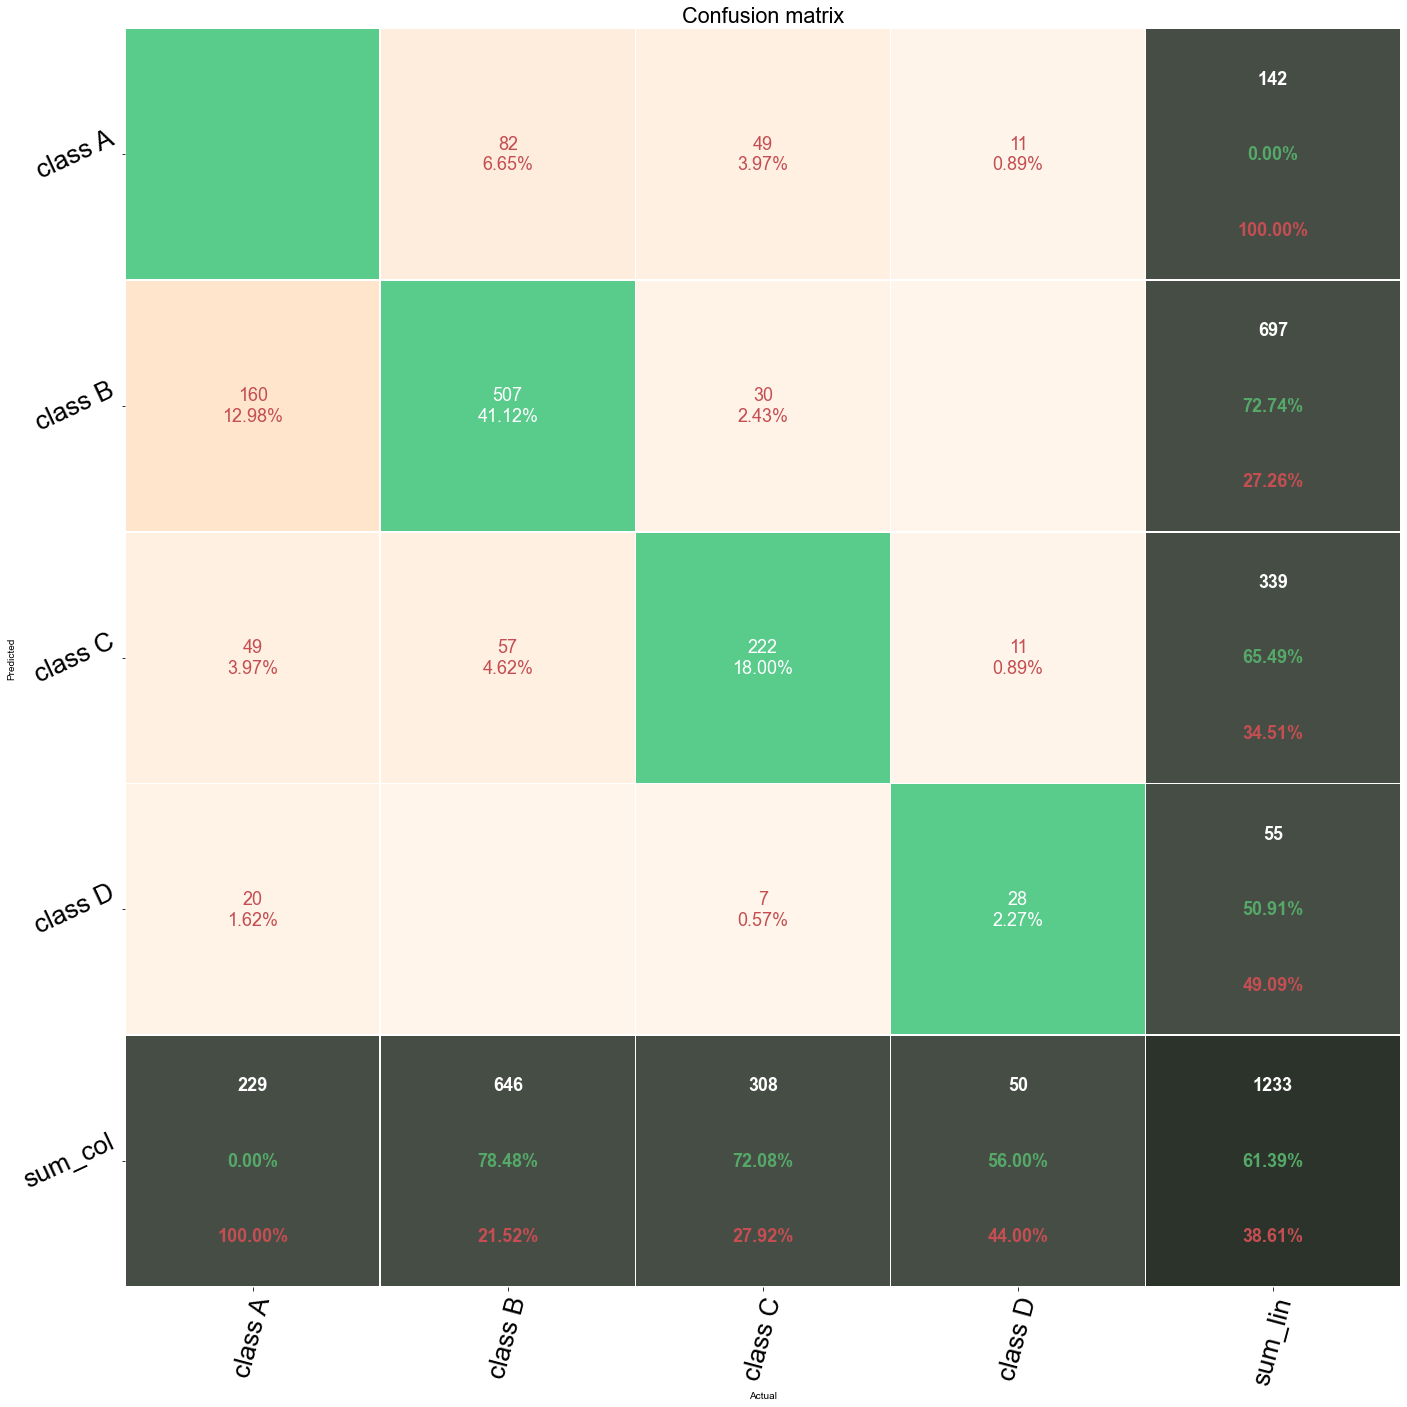

In [22]:
tp,fp,fn=utils_conf_matrix.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)

,gt_tot,pred_tot
0,2,2
1,2,2
2,1,1
3,1,1
4,0,1
...,...,...
1226,1,1
1227,1,1
1228,0,2
1229,2,1


In [23]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 507, 222, 28]
fp for each class : [142, 190, 117, 27]
fn for each class : [229, 139, 86, 22]

########################

tp for each class : [507, 222, 28]
fp for each class : [190, 117, 27]
fn for each class : [139, 86, 22]


m
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


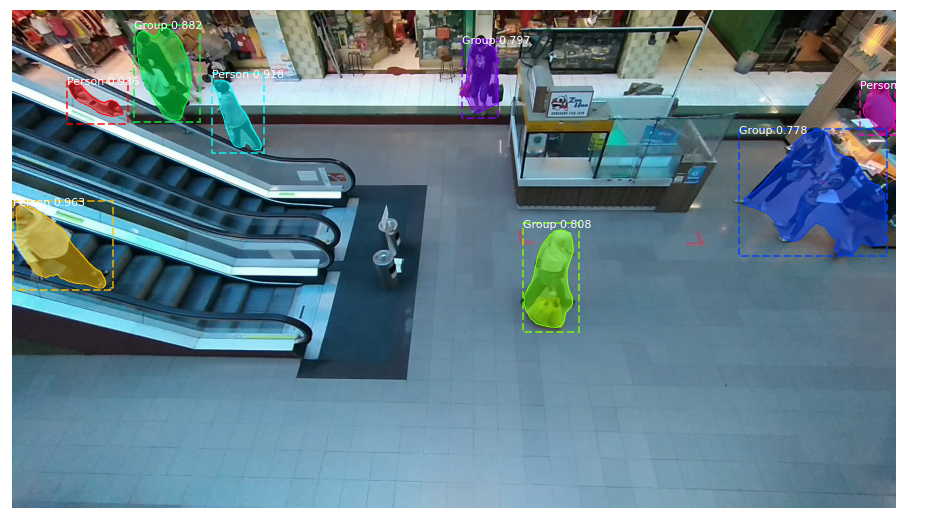

In [36]:
# This is for predicting images which are not present in dataset
import random
IMAGE_DIR = './dataset/test'
file_names = random.choice(os.listdir(IMAGE_DIR))
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))
print(random.choice(file_names))
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

#image_id = random.choice(dataset.image_ids)
#image1 = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/MaskRCNN/dataset/train/1 (100).jpg')

# Run object detection
#print(len([image1]))
#results1 = model.detect([image1], verbose=1)

    # Display results
#ax = get_ax(1)
#r1 = results1[0]
#visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names, r1['scores'], ax=ax,title="Predictions1")

## F1 Score, mAP (belum dicoba)

In [ ]:
def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

## Detect Image and then turn it into video

In [15]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image

In [17]:
ROOT_DIR = os.getcwd()
ROOT_DIR

'E:\\21. Coding Tesis\\2. Code Python 2 Transfer learning Dataset City'

In [20]:
import os
import sys
import utils

# Using ASUS with 8GB memory,.
batch_size = 1

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
#Change Video Save dir into folder name
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "T1801_Pasar_Atom_1")
MODEL_PATH = os.path.join(ROOT_DIR, "T1801_mask_rcnn_object_0052.h5")

config = CustomConfig()
#CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/15. R-CNN TESIS/SEMESTER_8/MASK_RCNN/dataset/testing")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()

model = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model.load_weights(MODEL_PATH, by_name=True)


capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'Pasar Atom 1.mp4'))
try:
    if not os.path.exists(VIDEO_SAVE_DIR):
        os.makedirs(VIDEO_SAVE_DIR)
except OSError:
    print ('Error: Creating directory of data')
frames = []
frame_count = 0
# these 2 lines can be removed if you dont have a 1080p camera.
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while True:
    ret, frame = capture.read()
    # Bail out when the video file ends
    if not ret:
        break

    # Save each frame of the video to a list
    frame_count += 1
    frames.append(frame)
    print('frame_count :{0}'.format(frame_count))
    if len(frames) == batch_size:
        results = model.detect(frames, verbose=0)
        print('Predicted')
        for i, item in enumerate(zip(frames, results)):
            frame = item[0]
            r = item[1]
            frame = display_instances(
                frame, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores']
            )
            name = '{0}.jpg'.format(frame_count + i - batch_size)
            name = os.path.join(VIDEO_SAVE_DIR, name)
            cv2.imwrite(name, frame)
            print('writing to file:{0}'.format(name))
        # Clear the frames array to start the next batch
        frames = []

capture.release()

frame_count :1
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\0.jpg
frame_count :2
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1.jpg
frame_count :3
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\2.jpg
frame_count :4
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\3.jpg
frame_count :5
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\4.jpg
frame_count :6
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\5.jpg
frame_count :7
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\6.jpg
frame_count :

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\58.jpg
frame_count :60
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\59.jpg
frame_count :61
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\60.jpg
frame_count :62
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\61.jpg
frame_count :63
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\62.jpg
frame_count :64
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\63.jpg
frame_count :65
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\64.jpg
frame_count :66

writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\115.jpg
frame_count :117
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\116.jpg
frame_count :118
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\117.jpg
frame_count :119
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\118.jpg
frame_count :120
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\119.jpg
frame_count :121
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\120.jpg
frame_count :122
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\121.jpg
frame_count 

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\172.jpg
frame_count :174
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\173.jpg
frame_count :175
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\174.jpg
frame_count :176
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\175.jpg
frame_count :177
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\176.jpg
frame_count :178
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\177.jpg
frame_count :179
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\178.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\229.jpg
frame_count :231
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\230.jpg
frame_count :232
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\231.jpg
frame_count :233
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\232.jpg
frame_count :234
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\233.jpg
frame_count :235
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\234.jpg
frame_count :236
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\235.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\286.jpg
frame_count :288
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\287.jpg
frame_count :289
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\288.jpg
frame_count :290
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\289.jpg
frame_count :291
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\290.jpg
frame_count :292
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\291.jpg
frame_count :293
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\292.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\343.jpg
frame_count :345
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\344.jpg
frame_count :346
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\345.jpg
frame_count :347
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\346.jpg
frame_count :348
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\347.jpg
frame_count :349
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\348.jpg
frame_count :350
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\349.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\400.jpg
frame_count :402
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\401.jpg
frame_count :403
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\402.jpg
frame_count :404
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\403.jpg
frame_count :405
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\404.jpg
frame_count :406
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\405.jpg
frame_count :407
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\406.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\457.jpg
frame_count :459
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\458.jpg
frame_count :460
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\459.jpg
frame_count :461
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\460.jpg
frame_count :462
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\461.jpg
frame_count :463
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\462.jpg
frame_count :464
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\463.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\514.jpg
frame_count :516
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\515.jpg
frame_count :517
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\516.jpg
frame_count :518
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\517.jpg
frame_count :519
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\518.jpg
frame_count :520
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\519.jpg
frame_count :521
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\520.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\571.jpg
frame_count :573
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\572.jpg
frame_count :574
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\573.jpg
frame_count :575
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\574.jpg
frame_count :576
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\575.jpg
frame_count :577
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\576.jpg
frame_count :578
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\577.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\628.jpg
frame_count :630
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\629.jpg
frame_count :631
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\630.jpg
frame_count :632
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\631.jpg
frame_count :633
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\632.jpg
frame_count :634
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\633.jpg
frame_count :635
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\634.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\685.jpg
frame_count :687
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\686.jpg
frame_count :688
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\687.jpg
frame_count :689
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\688.jpg
frame_count :690
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\689.jpg
frame_count :691
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\690.jpg
frame_count :692
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\691.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\742.jpg
frame_count :744
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\743.jpg
frame_count :745
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\744.jpg
frame_count :746
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\745.jpg
frame_count :747
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\746.jpg
frame_count :748
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\747.jpg
frame_count :749
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\748.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\799.jpg
frame_count :801
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\800.jpg
frame_count :802
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\801.jpg
frame_count :803
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\802.jpg
frame_count :804
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\803.jpg
frame_count :805
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\804.jpg
frame_count :806
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\805.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\856.jpg
frame_count :858
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\857.jpg
frame_count :859
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\858.jpg
frame_count :860
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\859.jpg
frame_count :861
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\860.jpg
frame_count :862
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\861.jpg
frame_count :863
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\862.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\913.jpg
frame_count :915
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\914.jpg
frame_count :916
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\915.jpg
frame_count :917
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\916.jpg
frame_count :918
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\917.jpg
frame_count :919
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\918.jpg
frame_count :920
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\919.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\970.jpg
frame_count :972
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\971.jpg
frame_count :973
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\972.jpg
frame_count :974
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\973.jpg
frame_count :975
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\974.jpg
frame_count :976
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\975.jpg
frame_count :977
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\976.jpg
fr

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1027.jpg
frame_count :1029
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1028.jpg
frame_count :1030
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1029.jpg
frame_count :1031
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1030.jpg
frame_count :1032
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1031.jpg
frame_count :1033
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1032.jpg
frame_count :1034
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1083.jpg
frame_count :1085
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1084.jpg
frame_count :1086
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1085.jpg
frame_count :1087
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1086.jpg
frame_count :1088
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1087.jpg
frame_count :1089
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1088.jpg
frame_count :1090
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1139.jpg
frame_count :1141
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1140.jpg
frame_count :1142
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1141.jpg
frame_count :1143
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1142.jpg
frame_count :1144
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1143.jpg
frame_count :1145
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1144.jpg
frame_count :1146
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1195.jpg
frame_count :1197
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1196.jpg
frame_count :1198
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1197.jpg
frame_count :1199
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1198.jpg
frame_count :1200
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1199.jpg
frame_count :1201
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1200.jpg
frame_count :1202
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1251.jpg
frame_count :1253
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1252.jpg
frame_count :1254
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1253.jpg
frame_count :1255
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1254.jpg
frame_count :1256
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1255.jpg
frame_count :1257
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1256.jpg
frame_count :1258
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1307.jpg
frame_count :1309
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1308.jpg
frame_count :1310
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1309.jpg
frame_count :1311
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1310.jpg
frame_count :1312
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1311.jpg
frame_count :1313
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1312.jpg
frame_count :1314
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1363.jpg
frame_count :1365
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1364.jpg
frame_count :1366
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1365.jpg
frame_count :1367
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1366.jpg
frame_count :1368
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1367.jpg
frame_count :1369
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1368.jpg
frame_count :1370
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1419.jpg
frame_count :1421
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1420.jpg
frame_count :1422
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1421.jpg
frame_count :1423
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1422.jpg
frame_count :1424
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1423.jpg
frame_count :1425
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1424.jpg
frame_count :1426
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1475.jpg
frame_count :1477
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1476.jpg
frame_count :1478
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1477.jpg
frame_count :1479
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1478.jpg
frame_count :1480
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1479.jpg
frame_count :1481
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1480.jpg
frame_count :1482
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1531.jpg
frame_count :1533
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1532.jpg
frame_count :1534
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1533.jpg
frame_count :1535
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1534.jpg
frame_count :1536
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1535.jpg
frame_count :1537
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1536.jpg
frame_count :1538
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1587.jpg
frame_count :1589
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1588.jpg
frame_count :1590
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1589.jpg
frame_count :1591
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1590.jpg
frame_count :1592
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1591.jpg
frame_count :1593
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1592.jpg
frame_count :1594
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1643.jpg
frame_count :1645
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1644.jpg
frame_count :1646
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1645.jpg
frame_count :1647
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1646.jpg
frame_count :1648
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1647.jpg
frame_count :1649
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1648.jpg
frame_count :1650
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1699.jpg
frame_count :1701
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1700.jpg
frame_count :1702
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1701.jpg
frame_count :1703
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1702.jpg
frame_count :1704
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1703.jpg
frame_count :1705
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1704.jpg
frame_count :1706
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1755.jpg
frame_count :1757
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1756.jpg
frame_count :1758
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1757.jpg
frame_count :1759
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1758.jpg
frame_count :1760
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1759.jpg
frame_count :1761
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_1\1760.jpg
frame_count :1762
Predicted
writing to file:E:\21. Coding Tesis\2. Code Python 2 Transfer learning Dataset City\videos\T1801_Pasar_Atom_

KeyboardInterrupt: 